<a href="https://colab.research.google.com/github/ladybuglady/Contrastive-Predictive-Coding-PyTorch/blob/master/SSL_ECG_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECG feature extraction using SAVER's self-supervised learning model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
## Load pretrained self-supervised model and ECG feature extraction model (adapted from extract_features.py)
import os
import tensorflow.compat.v1 as tf

# To make tf 2.0 compatible with tf1.0 code, we disable the tf2.0 functionalities (source: https://github.com/tensorflow/hub/issues/350#issuecomment-568924766)
tf.disable_eager_execution()

## specify the path where model is saved
model_path = os.path.abspath('./load_model/saved_model/')

# with tf.compat.v1.Session() as sess:
sess = tf.compat.v1.Session()
saver = tf.compat.v1.train.import_meta_graph(model_path + "/SSL_model.ckpt.meta")
new_saver = saver.restore(sess, tf.train.latest_checkpoint(model_path))
graph = tf.compat.v1.get_default_graph()

input_tensor       = graph.get_tensor_by_name("input:0")
drop_out           = graph.get_tensor_by_name("Drop_out:0")
isTrain            = graph.get_tensor_by_name(name = 'isTrain:0')

conv1              = graph.get_tensor_by_name(name = 'conv_layer_1/kernel:0') #output after conv layer 1
conv2              = graph.get_tensor_by_name(name = 'conv_layer_2/kernel:0') #output after conv layer 2
flat_layer1        = graph.get_tensor_by_name(name = 'flat_layer1/Reshape:0') #output after conv layer 1
conv3              = graph.get_tensor_by_name(name = 'conv_layer_3/kernel:0') #output after conv layer 3
conv4              = graph.get_tensor_by_name(name = 'conv_layer_4/kernel:0') #output after conv layer 4
flat_layer2        = graph.get_tensor_by_name(name = 'flat_layer2/Reshape:0') #output after conv layer 2
conv5              = graph.get_tensor_by_name(name = 'conv_layer_5/kernel:0') #output after conv layer 5
conv6              = graph.get_tensor_by_name(name = 'conv_layer_6/kernel:0') #output after conv layer 6
flat_layer3        = graph.get_tensor_by_name(name = 'flat_layer3/Reshape:0') #output after conv block 3

main_branch        = graph.get_tensor_by_name(name = 'flat_layer/Reshape:0') #output after all conv layers (ECG feature extractor)

print('Pretrained ECG feature extractor model loaded!')

INFO:tensorflow:Restoring parameters from /Users/Shayan/Desktop/StuyCS/Fifer Lab/Code/AI_ECG/SSL-ECGv2/load_model/saved_model/SSL_model.ckpt
Pretrained ECG feature extractor model loaded!


2024-01-03 18:36:55.782197: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2024-01-03 18:36:55.802532: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [ ]:
## Now load sample ECG data and make predictions on it (adapted from felicity.py)
# NOTE: This data was exported in a very specific format (where final_Om corresponds to the decomposed MATERNAL ECG signal)
# feel free to edit the code below to load your own data, or email me at sc4040@columbia.edu if you have any questions! :)
import pickle
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, './codes')
import preprocessing
import utils

# Load mat file
data_dict = pickle.load(open('./sample_ECG_data.pkl', 'rb'))

# Convert to pandas dataframe
df = pd.DataFrame.from_dict(data_dict)

# Preprocess ECG signals before passing to model (downsample, filter, normalize)
fs_og = 1000 # Original sampling frequency of ECG data collected
fs_new = 256 # Sampling frequency model was trained on

def normalize(x):
    """perform z-score normalization of a signal """
    temp = np.sort(x)
    x_std = np.std(temp[int(0.025*temp.shape[0]) : int(0.975*temp.shape[0])])
    x_mean = np.mean(temp)
    x_scaled = (x-x_mean)/x_std
    return x_scaled

def ecg_preprocess(sig, old_sampling_freq, new_sampling_freq):
    sig = utils.downsample(sig, old_sampling_freq, new_sampling_freq).reshape(-1, )
    sig = preprocessing.filter_ecg(sig, new_sampling_freq)
    sig = normalize(sig)
    return sig
df['final_Om'] = df['final_Om'].apply(lambda x: ecg_preprocess(x[0], fs_og, fs_new))

# Drop first and last minute (often noisy)
df = df[1:len(df)-1].dropna().reset_index(drop=True)

In [ ]:
# Split into 10 second segments instead of 60 (since that's what the model was trained on)
data_splits = [] # List of dictionaries, each dictionary contains 10 second segment of ECG and corresponding labels
prev_seg_proc_time = 0 # Keep track of processing time for each segment
for index, row in df.iterrows(): # Yes, not the most efficient way to do this, but it works and is readable!
    for i in range(6):
        seg_proc_time = prev_seg_proc_time + row['final_proc_time'][0] / 6
        data_splits.append({
            'final_file_names': row['final_file_names'][0],
            'final_start_times': (index * 60) + i * 10,
            'final_Of': row['final_Of'][0][i*10*fs_new : (i+1)*10*fs_new],
            'final_Om': row['final_Om'][i*10*fs_new : (i+1)*10*fs_new],
            'final_aECG': row['final_aECG'][0][i*10*fs_new : (i+1)*10*fs_new],
            'final_og_ECG': row['final_og_ECG'][0][0][i*10*fs_new : (i+1)*10*fs_new],
            'final_SQI': row['final_SQI'][0],
            'final_chs_used': row['final_chs_used'][0],
            # 'final_fbeats',
            # 'final_mbeats',
            'final_proc_time': seg_proc_time,
            'final_sleep_states': row['final_sleep_states'][0],
        })
        prev_seg_proc_time = seg_proc_time

df_split = pd.DataFrame(data_splits)
df_split

,final_file_names,final_start_times,final_Of,final_Om,final_aECG,final_og_ECG,final_SQI,final_chs_used,final_proc_time,final_sleep_states
0,test_file,0,"[7.12164608583286, 7.801855060636188, 8.274811...","[-0.017180917168253346, -0.03436775353827228, ...","[-1.7790034720064152, -2.590170042677108, -3.2...","[8337.592866969302, 8337.366196959572, 8337.06...",0.8,"[1.0, 3.0]",13.820324,i
1,test_file,10,"[-7.498322353963891, -7.141686154049773, -6.86...","[-0.1684211934766956, -0.45540867073983116, -0...","[-15.655389714339996, -25.934715321127882, -34...","[8326.218937893453, 8314.608600983256, 8302.28...",0.8,"[1.0, 3.0]",27.640649,i
2,test_file,20,"[-2.416766177733244, -1.6433334272640763, -0.6...","[0.11992022643324728, 0.2821730921004684, 0.33...","[-55.83795429164496, -54.82353251250892, -53.0...","[8517.441759333085, 8516.68387795531, 8514.523...",0.8,"[1.0, 3.0]",41.460973,i
3,test_file,30,"[-0.20075298076584305, 0.06459342571736132, 0....","[0.348067612069372, 0.17806825355252215, 0.160...","[79.11330151968231, 93.62741590922681, 107.807...","[8427.43308770551, 8451.533118039177, 8470.504...",0.8,"[1.0, 3.0]",55.281297,i
4,test_file,40,"[2.439097424423262, 2.1438380230963983, 2.0423...","[0.35769210040333105, 0.30207878089933127, 0.3...","[-10.999170388228695, -13.44490660203352, -14....","[8316.772105010125, 8315.739924421014, 8314.84...",0.8,"[1.0, 3.0]",69.101622,i
...,...,...,...,...,...,...,...,...,...,...
337,test_file,3370,"[-1.5558917593792208, -1.495934465030556, -1.7...","[-0.2634387841741585, -0.19436572791001783, -0...","[26.553594254612957, 27.08988333800102, 22.460...","[8296.238477329354, 8293.941262748891, 8292.81...",1.0,"[2.0, 3.0]",64055.781608,i
338,test_file,3380,"[-0.9240080289742033, -0.9125807608192131, -0....","[0.0015545919277595353, -0.04467615088039123, ...","[-76.34915725093992, -72.19619548410839, -63.5...","[8362.752251724418, 8375.284774447995, 8383.65...",1.0,"[2.0, 3.0]",64434.505237,i
339,test_file,3390,"[-2.152052610202669, -2.196399271209707, -2.24...","[0.5462650193492568, 0.22870628196229317, -0.1...","[92.56539146918223, 86.53738073593752, 83.1737...","[8454.310913633872, 8453.737465410984, 8452.83...",1.0,"[2.0, 3.0]",64813.228867,i
340,test_file,3400,"[0.6041972386128083, 0.8057061930301144, -0.62...","[-0.2715881504403629, -0.39604985171131185, -0...","[7.713901715045253, 4.474690079444633, -2.0823...","[8292.894808206718, 8298.651716755267, 8306.75...",1.0,"[2.0, 3.0]",65191.952497,i


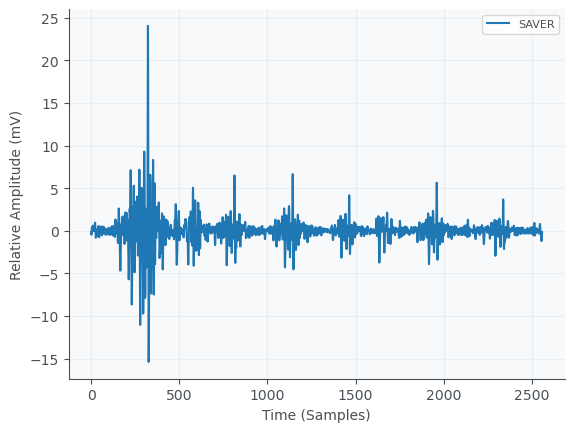

In [ ]:
# Plot one of the new 10s ECG segments
import matplotlib.pyplot as plt
idx = 1
sig_saver = df_split.iloc[idx]['final_Om'] # Reminder: only using the maternal ECG signal
plt.plot(sig_saver, label="SAVER")
plt.xlabel('Time (Samples)')
plt.ylabel('Relative Amplitude (mV)')
plt.legend()

In [ ]:
## Use the pretrained model to extract features from the entire maternal ECG signal
from tqdm.auto import tqdm
batch_size = 4

# Calculate the length of sample ecg file (number of rows)
length = len(df_split)
# Initialize an array to save extracted features
feature_set = np.zeros((1, main_branch.get_shape()[1]), dtype=int)
steps = length // batch_size + 1

for j in tqdm(range(steps)):
    # Get batch
    signal_batch = df_split['final_Om'][
        np.mod(np.arange(j * batch_size, (j + 1) * batch_size), length)
    ]
    signal_batch = np.vstack(signal_batch)
    # signal_batch = signal_batch.reshape(-1, fs_new * 10)
    # Reshape to feed into 1D conv layers
    signal_batch = np.expand_dims(signal_batch, 2)

    # Fetch output from last conv layer
    fetches = [main_branch]
    fetched = sess.run(
        fetches, {input_tensor: signal_batch, isTrain: False, drop_out: 0.0}
    )
    stacked = fetched[0]

    # stacking extracted features
    feature_set = np.vstack((feature_set, stacked))

# Removing the first row of zeros
x_ecg_feature = feature_set[1 : length + 1]

  0%|          | 0/86 [00:00<?, ?it/s]

In [ ]:
# Just to check that the number of segments and features are correct
print(f"Number of maternal ECG segments: {df_split['final_Om'].shape[0]}")
print(f"Shape of extracted features: {x_ecg_feature.shape}")

Number of maternal ECG segments: 342
Shape of extracted features: (342, 128)
